In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.7 MB/s eta 0:00:00


# 0. Importar bibliotecas

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import time
import lightgbm as lgb
import catboost as cb
import joblib
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import optuna
from optuna.samplers import TPESampler
from optuna.study import MaxTrialsCallback
from optuna.trial import TrialState

# Suprimir os alertas do LightGBM
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# 1. Leitura dos datasets

In [4]:
# Note que neste momento importamos as bases contendo todas as variáveis criadas no dataprep

train = pd.read_csv('/content/drive/MyDrive/Previsao_Demandas_PoD_Academy/train_002.csv')
val = pd.read_csv('/content/drive/MyDrive/Previsao_Demandas_PoD_Academy/val_002.csv')

In [5]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,oil_price,city,state,type,...,sales_rolling_mean_180,sales_rolling_mean_360,year,month,day,day_of_week,is_weekend,sales_oil_price_interaction_mult,sales_oil_price_interaction_div,target
0,1291950,2014-12-29,1,AUTOMOTIVE,1.0,0,53.46,Quito,Pichincha,D,...,3.066667,2.811111,2014,12,29,0,False,53.46,0.018706,44.0
1,1293732,2014-12-30,1,AUTOMOTIVE,4.0,0,54.14,Quito,Pichincha,D,...,3.083333,2.822222,2014,12,30,1,False,216.56,0.073883,40.0
2,1295514,2014-12-31,1,AUTOMOTIVE,0.0,0,53.45,Quito,Pichincha,D,...,3.061111,2.822222,2014,12,31,2,False,0.00,0.000000,43.0
3,1299078,2015-01-02,1,AUTOMOTIVE,2.0,0,52.72,Quito,Pichincha,D,...,3.022222,2.808333,2015,1,2,4,False,105.44,0.037936,44.0
4,1300860,2015-01-03,1,AUTOMOTIVE,6.0,0,50.05,Quito,Pichincha,D,...,3.050000,2.819444,2015,1,3,5,True,250.25,0.099900,43.0


In [6]:
val.head()

,id,date,store_nbr,family,sales,onpromotion,oil_price,city,state,type,...,sales_rolling_mean_180,sales_rolling_mean_360,year,month,day,day_of_week,is_weekend,sales_oil_price_interaction_mult,sales_oil_price_interaction_div,target
0,2756754,2017-04-01,1,AUTOMOTIVE,9.0,0,50.25,Quito,Pichincha,D,...,3.783333,4.069444,2017,4,1,5,True,552.75,0.218905,79.0
1,2758536,2017-04-02,1,AUTOMOTIVE,4.0,0,50.25,Quito,Pichincha,D,...,3.777778,4.061111,2017,4,2,6,True,552.75,0.218905,76.0
2,2760318,2017-04-03,1,AUTOMOTIVE,11.0,0,50.25,Quito,Pichincha,D,...,3.811111,4.077778,2017,4,3,0,False,552.75,0.218905,66.0
3,2762100,2017-04-04,1,AUTOMOTIVE,3.0,0,50.99,Quito,Pichincha,D,...,3.777778,4.061111,2017,4,4,1,False,152.97,0.058835,66.0
4,2763882,2017-04-05,1,AUTOMOTIVE,5.0,0,51.14,Quito,Pichincha,D,...,3.750000,4.063889,2017,4,5,2,False,255.70,0.097771,65.0


In [7]:
# Metadados referente ao conjunto de dados
def pod_academy_generate_metadata(dataframe):
    """
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    :param dataframe: DataFrame para o qual os metadados serão gerados.
    :return: DataFrame contendo metadados.
    """

    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes,
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': round((dataframe.isnull().sum() / len(dataframe))* 100,2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata=metadata.sort_values(by='percent_nulos',ascending=False)
    metadata = metadata.reset_index(drop=True)

    return metadata

pod_academy_generate_metadata(train)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,id,int64,0,0.0,134706
1,sales_rolling_mean_60,float64,0,0.0,61798
2,sales_lag_150,float64,0,0.0,34507
3,sales_lag_180,float64,0,0.0,34486
4,sales_lag_360,float64,0,0.0,33919
5,sales_rolling_mean_3,float64,0,0.0,41647
6,sales_rolling_mean_5,float64,0,0.0,44202
7,sales_rolling_mean_7,float64,0,0.0,46179
8,sales_rolling_mean_14,float64,0,0.0,50659
9,sales_rolling_mean_21,float64,0,0.0,53547


# 2. Avaliar modelo vigente

In [8]:
# Carregar o modelo salvo
pipeline_vigente = joblib.load('/content/drive/MyDrive/Previsao_Demandas_PoD_Academy/pipeline_model.pkl')

# Definir features e target
features = [col for col in train.columns if col not in ['id','date','target']]
target = 'target'

# Separar as colunas numéricas e categóricas
numeric_features = train[features].select_dtypes(include=['int64', 'float64']).columns
categorical_features = train[features].select_dtypes(include=['object']).columns

train.loc[:,categorical_features] = train[categorical_features].astype(str)
train.loc[:,categorical_features] = train[categorical_features].astype(str)

X_train = train[features]
y_train = train[target]
X_test = val[features]
y_test = val[target]

# Previsões no treino
train_predictions = pipeline_vigente.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)

# Previsões no teste
test_predictions = pipeline_vigente.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)

results = []
model_name = 'Modelo Vigente'

results.append((model_name, train_rmse, test_rmse, train_mae, test_mae))

# Mostrar os resultados
results_df1_vigente = pd.DataFrame(results, columns=['Model', 'Train RMSE', 'Test RMSE', 'Train MAE', 'Test MAE'])

results_df1_vigente

,Model,Train RMSE,Test RMSE,Train MAE,Test MAE
0,Modelo Vigente,10948.499005,10910.384667,3395.166383,3287.100141


# 3. Treinar novos algoritmos

## 3.1 Treinar novos algoritmos com o máximo de histórico possível

In [9]:
X_train = train[features]
y_train = train[target]
X_test = val[features]
y_test = val[target]

# Preprocessamento para dados numéricos e categóricos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Definir os modelos a serem testados
models = {
    'LinearRegression': LinearRegression(),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    'CatBoost': cb.CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=0),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

# Função para treinar e avaliar modelos
def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = []
    for model_name, model in models.items():
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('model', model)])

        print(f'Treinando o algoritmo: {model_name}')
        start_time = time.time()
        pipeline.fit(X_train, y_train)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f'Treino finalizado. Tempo gasto no treinamento: {elapsed_time:.2f} segundos')

        # Previsões no treino
        train_predictions = pipeline.predict(X_train)
        train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
        train_mae = mean_absolute_error(y_train, train_predictions)

        # Previsões no teste
        test_predictions = pipeline.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
        test_mae = mean_absolute_error(y_test, test_predictions)

        results.append((model_name, train_rmse, test_rmse, train_mae, test_mae))
        print(f"RMSE no treino: {train_rmse} \n"
              f"RMSE no teste: {test_rmse} \n"
              f"MAE no treino: {train_mae} \n"
              f"MAE no teste: {test_mae} \n"
              f"{70*'-'}")

    return results

# Avaliar os modelos
results = evaluate_models(models, X_train, y_train, X_test, y_test)

# Mostrar os resultados
results_df1 = pd.DataFrame(results, columns=['Model', 'Train RMSE', 'Test RMSE', 'Train MAE', 'Test MAE'])

results_df1

Treinando o algoritmo: LinearRegression
Treino finalizado. Tempo gasto no treinamento: 4.26 segundos
RMSE no treino: 2942.14890674139 
RMSE no teste: 1236.3698640759433 
MAE no treino: 670.2016248264923 
MAE no teste: 492.3509926248356 
----------------------------------------------------------------------
Treinando o algoritmo: LightGBM
Treino finalizado. Tempo gasto no treinamento: 11.26 segundos
RMSE no treino: 1017.0057922418011 
RMSE no teste: 1619.8959863399143 
MAE no treino: 335.07014391915123 
MAE no teste: 500.3504056836479 
----------------------------------------------------------------------
Treinando o algoritmo: CatBoost
Treino finalizado. Tempo gasto no treinamento: 11.82 segundos
RMSE no treino: 1603.6483071607972 
RMSE no teste: 1285.3497591702562 
MAE no treino: 508.98806146158546 
MAE no teste: 486.89666217352294 
----------------------------------------------------------------------
Treinando o algoritmo: GradientBoosting
Treino finalizado. Tempo gasto no treinamen

,Model,Train RMSE,Test RMSE,Train MAE,Test MAE
0,LinearRegression,2942.148907,1236.369864,670.201625,492.350993
1,LightGBM,1017.005792,1619.895986,335.070144,500.350406
2,CatBoost,1603.648307,1285.349759,508.988061,486.896662
3,GradientBoosting,1670.240404,1728.823477,499.316015,556.026406
4,XGBoost,526.359162,2700.234342,228.657446,669.275773


## 3.2 Treinar algoritmos com histórico a partir de Agosto/2015

In [ ]:
# Definir features e target
features = [col for col in train.columns if col not in ['id','date','target']]
target = 'target'

train_aux = train[train.date >= '2015-08-01'].copy()

# Separar as colunas numéricas e categóricas
numeric_features = train_aux[features].select_dtypes(include=['int64', 'float64']).columns
categorical_features = train_aux[features].select_dtypes(include=['object']).columns

train_aux.loc[:,categorical_features] = train_aux[categorical_features].astype(str)
train_aux.loc[:,categorical_features] = train_aux[categorical_features].astype(str)

X_train = train_aux[features]
y_train = train_aux[target]
X_test = val[features]
y_test = val[target]

# Preprocessamento para dados numéricos e categóricos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Definir os modelos a serem testados
models = {
    'LinearRegression': LinearRegression(),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    'CatBoost': cb.CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=0),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

# Função para treinar e avaliar modelos
def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = []
    for model_name, model in models.items():
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('model', model)])

        print(f'Treinando o algoritmo: {model_name}')
        start_time = time.time()
        pipeline.fit(X_train, y_train)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f'Treino finalizado. Tempo gasto no treinamento: {elapsed_time:.2f} segundos')

        # Previsões no treino
        train_predictions = pipeline.predict(X_train)
        train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
        train_mae = mean_absolute_error(y_train, train_predictions)

        # Previsões no teste
        test_predictions = pipeline.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
        test_mae = mean_absolute_error(y_test, test_predictions)

        results.append((model_name, train_rmse, test_rmse, train_mae, test_mae))
        print(f"RMSE no treino: {train_rmse} \n"
              f"RMSE no teste: {test_rmse} \n"
              f"MAE no treino: {train_mae} \n"
              f"MAE no teste: {test_mae} \n"
              f"{70*'-'}")

    return results

# Avaliar os modelos
results = evaluate_models(models, X_train, y_train, X_test, y_test)

# Mostrar os resultados
results_df2 = pd.DataFrame(results, columns=['Model', 'Train RMSE', 'Test RMSE', 'Train MAE', 'Test MAE'])

results_df2

Treinando o algoritmo: LinearRegression
Treino finalizado. Tempo gasto no treinamento: 1.30 segundos
RMSE no treino: 2814.308188868517 
RMSE no teste: 2000.3918438431365 
MAE no treino: 631.5547669042029 
MAE no teste: 535.3696174760606 
----------------------------------------------------------------------
Treinando o algoritmo: LightGBM
Treino finalizado. Tempo gasto no treinamento: 3.37 segundos
RMSE no treino: 890.9240520669903 
RMSE no teste: 3653.708048365755 
MAE no treino: 309.58565369885747 
MAE no teste: 769.9644631624195 
----------------------------------------------------------------------
Treinando o algoritmo: CatBoost
Treino finalizado. Tempo gasto no treinamento: 7.61 segundos
RMSE no treino: 1409.2684487322508 
RMSE no teste: 2898.3151844550043 
MAE no treino: 469.8874795647781 
MAE no teste: 759.223901749313 
----------------------------------------------------------------------
Treinando o algoritmo: GradientBoosting
Treino finalizado. Tempo gasto no treinamento: 18

,Model,Train RMSE,Test RMSE,Train MAE,Test MAE
0,LinearRegression,2814.308189,2000.391844,631.554767,535.369617
1,LightGBM,890.924052,3653.708048,309.585654,769.964463
2,CatBoost,1409.268449,2898.315184,469.887480,759.223902
3,GradientBoosting,1452.971989,1604.839811,443.847684,519.540360
4,XGBoost,441.735762,3031.808089,199.418312,769.237393


## 3.3 Treinar algoritmos com histórico a partir de Janeiro/2017

In [ ]:
# Definir features e target
features = [col for col in train.columns if col not in ['id','date','target']]
target = 'target'

train_aux = train[train.date >= '2017-01-01'].copy()

# Separar as colunas numéricas e categóricas
numeric_features = train_aux[features].select_dtypes(include=['int64', 'float64']).columns
categorical_features = train_aux[features].select_dtypes(include=['object']).columns

train_aux.loc[:,categorical_features] = train_aux[categorical_features].astype(str)
train_aux.loc[:,categorical_features] = train_aux[categorical_features].astype(str)

X_train = train_aux[features]
y_train = train_aux[target]
X_test = val[features]
y_test = val[target]

# Preprocessamento para dados numéricos e categóricos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Definir os modelos a serem testados
models = {
    'LinearRegression': LinearRegression(),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    'CatBoost': cb.CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=0),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Função para treinar e avaliar modelos
def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = []
    for model_name, model in models.items():
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('model', model)])

        print(f'Treinando o algoritmo: {model_name}')
        start_time = time.time()
        pipeline.fit(X_train, y_train)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f'Treino finalizado. Tempo gasto no treinamento: {elapsed_time:.2f} segundos')

        # Previsões no treino
        train_predictions = pipeline.predict(X_train)
        train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
        train_mae = mean_absolute_error(y_train, train_predictions)

        # Previsões no teste
        test_predictions = pipeline.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
        test_mae = mean_absolute_error(y_test, test_predictions)

        results.append((model_name, train_rmse, test_rmse, train_mae, test_mae))
        print(f"RMSE no treino: {train_rmse} \n"
              f"RMSE no teste: {test_rmse} \n"
              f"MAE no treino: {train_mae} \n"
              f"MAE no teste: {test_mae} \n"
              f"{70*'-'}")

    return results

# Avaliar os modelos
results = evaluate_models(models, X_train, y_train, X_test, y_test)

# Mostrar os resultados
results_df3 = pd.DataFrame(results, columns=['Model', 'Train RMSE', 'Test RMSE', 'Train MAE', 'Test MAE'])

results_df3

Treinando o algoritmo: LinearRegression
Treino finalizado. Tempo gasto no treinamento: 0.80 segundos
RMSE no treino: 950.7420457917415 
RMSE no teste: 2316.1263255847452 
MAE no treino: 369.5090545863599 
MAE no teste: 837.5566003293497 
----------------------------------------------------------------------
Treinando o algoritmo: LightGBM
Treino finalizado. Tempo gasto no treinamento: 0.79 segundos
RMSE no treino: 244.350112115593 
RMSE no teste: 1889.0787874954983 
MAE no treino: 125.14838113249132 
MAE no teste: 649.1993239831393 
----------------------------------------------------------------------
Treinando o algoritmo: CatBoost
Treino finalizado. Tempo gasto no treinamento: 3.68 segundos
RMSE no treino: 749.4213298626354 
RMSE no teste: 1770.0999216954328 
MAE no treino: 354.3218234020311 
MAE no teste: 642.2546568115732 
----------------------------------------------------------------------
Treinando o algoritmo: GradientBoosting
Treino finalizado. Tempo gasto no treinamento: 22

,Model,Train RMSE,Test RMSE,Train MAE,Test MAE
0,LinearRegression,950.742046,2316.126326,369.509055,837.556600
1,LightGBM,244.350112,1889.078787,125.148381,649.199324
2,CatBoost,749.421330,1770.099922,354.321823,642.254657
3,GradientBoosting,488.075196,1968.863508,208.381563,655.757094
4,XGBoost,99.561975,1877.514727,59.353241,639.895013
5,RandomForest,162.107595,2030.747099,44.287965,730.590707


* Comparar os resultados das três abordagens

In [ ]:
# Comparar os resultados das três abordagens
results_df1

,Model,Train RMSE,Test RMSE,Train MAE,Test MAE
0,LinearRegression,2942.148907,1236.369864,670.201625,492.350993
1,LightGBM,1017.005792,1619.895986,335.070144,500.350406
2,CatBoost,1603.648307,1285.349759,508.988061,486.896662
3,GradientBoosting,1670.240404,1728.823477,499.316015,556.026406
4,XGBoost,526.359162,2700.234342,228.657446,669.275773


In [ ]:
results_df2

,Model,Train RMSE,Test RMSE,Train MAE,Test MAE
0,LinearRegression,2814.308189,2000.391844,631.554767,535.369617
1,LightGBM,890.924052,3653.708048,309.585654,769.964463
2,CatBoost,1409.268449,2898.315184,469.887480,759.223902
3,GradientBoosting,1452.971989,1604.839811,443.847684,519.540360
4,XGBoost,441.735762,3031.808089,199.418312,769.237393


In [ ]:
results_df3

,Model,Train RMSE,Test RMSE,Train MAE,Test MAE
0,LinearRegression,950.742046,2316.126326,369.509055,837.556600
1,LightGBM,244.350112,1889.078787,125.148381,649.199324
2,CatBoost,749.421330,1770.099922,354.321823,642.254657
3,GradientBoosting,488.075196,1968.863508,208.381563,655.757094
4,XGBoost,99.561975,1877.514727,59.353241,639.895013
5,RandomForest,162.107595,2030.747099,44.287965,730.590707


Pode-se notar que o melhor algoritmo até o momento foi o CatBoost na versão que utiliza para treinamento do modelo todo o histórico disponível. Deve-se ressaltar que este modelo já é significativamente melhor que o modelo vigente.

# 3.4 Testando o LSTM - utilizando todo o histórico de dados disponível

In [ ]:
# Definir features e target
features = [col for col in train.columns if col not in ['id','date','target']]
target = 'target'

# Separar as colunas numéricas e categóricas
numeric_features = train[features].select_dtypes(include=['int64', 'float64']).columns
categorical_features = train[features].select_dtypes(include=['object']).columns

train.loc[:,categorical_features] = train[categorical_features].astype(str)
train.loc[:,categorical_features] = train[categorical_features].astype(str)

X_train = train[features]
y_train = train[target]
X_test = val[features]
y_test = val[target]

# Preprocessamento para dados numéricos e categóricos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Fixando a seed
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Função para criar e compilar o modelo LSTM
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed_value)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Converter os DataFrames para arrays NumPy
X_train_scaled = pipeline.fit_transform(X_train, y_train)
X_test_scaled = pipeline.transform(X_test)

# Redimensionar novamente após a normalização
X_train_scaled_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Criar o modelo LSTM
model = create_lstm_model((1, X_train_scaled.shape[1]))

# Treinar o modelo LSTM
print('Treinando o modelo LSTM...')
model.fit(X_train_scaled_reshaped, y_train, epochs=10, batch_size=32, verbose=0)

# Previsões e avaliação
train_predictions = model.predict(X_train_scaled_reshaped)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)

test_predictions = model.predict(X_test_scaled_reshaped)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)

# Resultados
results = ('LSTM', train_rmse, test_rmse, train_mae, test_mae)
print(f"Resultados do modelo LSTM:\n"
      f"RMSE no treino: {train_rmse} \n"
      f"RMSE no teste: {test_rmse} \n"
      f"MAE no treino: {train_mae} \n"
      f"MAE no teste: {test_mae}")

# Caso deseje adicionar os resultados ao DataFrame de resultados:
results_df1.loc[len(results_df1)] = results

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Treinando o modelo LSTM...
4210/4210 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Resultados do modelo LSTM:
RMSE no treino: 2623.477598872533 
RMSE no teste: 1143.2012125196518 
MAE no treino: 520.7898179755607 
MAE no teste: 418.6269508705702


# 4. Tunar hiperparâmetros do melhor algoritmo

In [ ]:
X_train = train[features]
y_train = train[target]
X_test = val[features]
y_test = val[target]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Função objetiva para a otimização do Optuna
def objective(trial):
    # Sugerir valores para os hiperparâmetros
    iterations = trial.suggest_int('iterations', 50, 1000)
    depth = trial.suggest_int('depth', 4, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-8, 1e-3, log=True)
    bagging_temperature = trial.suggest_float('bagging_temperature', 0.0, 1.0)
    border_count = trial.suggest_int('border_count', 32, 255)

    # Definir o modelo com os hiperparâmetros sugeridos
    model = cb.CatBoostRegressor(
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        bagging_temperature=bagging_temperature,
        border_count=border_count,
        loss_function='RMSE',
        verbose=0
    )

    # Pipeline com o preprocessador e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])

    # Treinar o pipeline
    pipeline.fit(X_train, y_train)

    # Prever no conjunto de validação
    y_pred = pipeline.predict(X_test)

    # Calcular o erro quadrático médio
    mse = mean_squared_error(y_test, y_pred)

    return mse

class EarlyStoppingCallback:
    def __init__(self, patience: int):
        self.patience = patience
        self.best_score = None
        self.num_no_improvement = 0

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial):
        current_score = study.best_value
        if self.best_score is None or current_score < self.best_score:
            self.best_score = current_score
            self.num_no_improvement = 0
        else:
            self.num_no_improvement += 1

        if self.num_no_improvement >= self.patience:
            study.stop()

# Crie o estudo e defina o callback para parar após 10 iterações sem melhorias
early_stopping = EarlyStoppingCallback(patience=10)

# Criação do estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=70, n_jobs=-1, callbacks=[early_stopping])

# Melhor conjunto de hiperparâmetros encontrado
print(f"Melhores hiperparâmetros: {study.best_params}")
print(f"Melhor MSE: {study.best_value:.4f}")

[I 2024-08-17 03:40:59,470] A new study created in memory with name: no-name-f002587a-5e22-4c71-b37d-5357e07307a9
[I 2024-08-17 03:41:22,171] Trial 0 finished with value: 1569633.816889328 and parameters: {'iterations': 153, 'depth': 4, 'learning_rate': 0.0929716422823621, 'l2_leaf_reg': 3.518617618493957e-05, 'bagging_temperature': 0.25866335352036973, 'border_count': 141}. Best is trial 0 with value: 1569633.816889328.
[I 2024-08-17 03:42:18,340] Trial 1 finished with value: 1430787.373395042 and parameters: {'iterations': 608, 'depth': 8, 'learning_rate': 0.01351875555083623, 'l2_leaf_reg': 1.763789329093008e-07, 'bagging_temperature': 0.8672941916725895, 'border_count': 170}. Best is trial 1 with value: 1430787.373395042.
[I 2024-08-17 03:42:18,664] Trial 2 finished with value: 1421720.752559813 and parameters: {'iterations': 565, 'depth': 6, 'learning_rate': 0.020016387076331334, 'l2_leaf_reg': 3.004726706854299e-08, 'bagging_temperature': 0.710119905006255, 'border_count': 182}. 

Melhores hiperparâmetros: {'iterations': 216, 'depth': 9, 'learning_rate': 0.01814185307801928, 'l2_leaf_reg': 2.4705903589841185e-06, 'bagging_temperature': 0.3191603023289703, 'border_count': 194}
Melhor MSE: 1008454.3758


### 4.1 Conhecendo um pouco mais dos hiperparâmetros que fizemos o "tuning"

1.   `iterations` = Quantidade de iterações (árvores) construídas durante o treinamento. Quanto mais árvores maior a capacidade de capturar padrões complexos nos dados, o que pode provocar o sobreajuste (overfitting);
2.   `depth` = Profundidade das árvores criadas. Profundidades maiores permitem capturar interações mais complexas entre as variáveis, mas também aumentam o risco de sobreajuste. Profundidades menores produzem árvores mais simples que podem generalizar melhor, mas com menor capacidade de ajuste;
3.   `learning_rate` = Taxa de aprendizado. Quanto menor taxa, mais lento será o treinamento, entretanto isso permite ajustes finos e consequentemente um modelo mais robusto. Uma taxa muito alta pode levar a um treinamento rápido, mas com o risco de passar por mínimos ótimos (subótimos);
4.   `l2_leaf_reg` = Termo de regularização L2 aplicado nas folhas das árvores de decisão. A regularização L2 ajuda a prevenir o sobreajuste ao penalizar grandes coeficientes nos modelos de árvore, o que força as previsões a serem mais conservadoras. É crucial para controlar a complexidade do modelo;
5.   `bagging_temperature` = Controla a intensidade da amostragem aleatória das observações durante a construção de cada árvore (uma técnica chamada bagging). Um valor alto de bagging_temperature promove mais aleatoriedade, o que pode aumentar a robustez do modelo, mas pode também aumentar a variância. Um valor baixo reduz a aleatoriedade, o que pode tornar o modelo mais estável, mas potencialmente menos robusto;
6.   `border_count` = Refere-se ao número de limites utilizados para discretizar as características numéricas antes de alimentar os valores nas árvores.Mais bordas permitem capturar detalhes mais finos dos dados, mas aumentam o custo computacional e o risco de sobreajuste. Menos bordas simplificam o modelo e podem ajudar na generalização.

# 5. Salvar melhor modelo

Nesta seção salvaremos todo o pipeline contendo o dataprep e o algoritmo que teve melhor desempenho nos testes realizados.

In [ ]:
# Melhor modelo treinado
best_params = study.best_params
best_model = cb.CatBoostRegressor(**best_params, loss_function='RMSE', verbose=0)

# Recriar o pipeline com os melhores parâmetros
pipeline_best_model = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('model', best_model)])

# Treinar o pipeline final no conjunto de treinamento completo
pipeline_best_model.fit(X_train, y_train)

# Salvando o pipeline em um arquivo .pkl
joblib.dump(pipeline_best_model, '/content/drive/MyDrive/Previsao_Demandas_PoD_Academy/pipeline_best_model_all_features_catboost.pkl')

['/content/drive/MyDrive/Previsao_Demandas_PoD_Academy/pipeline_best_model_all_features_catboost.pkl']

In [ ]:
# Conferindo o desempenho da versão salva

results = []

# Previsões no teste
test_predictions = pipeline_best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)

print(f"RMSE no treino: {train_rmse} \n"
      f"RMSE no teste: {test_rmse} \n"
      f"MAE no treino: {train_mae} \n"
      f"MAE no teste: {test_mae} \n"
      f"{70*'-'}")

RMSE no treino: 10948.49900478715 
RMSE no teste: 1004.2182908920599 
MAE no treino: 3395.1663829153254 
MAE no teste: 442.2136885003837 
----------------------------------------------------------------------


# 6. Voting Ensemble

## 6.1. Tunar hiperparâmetros da Regressão Linear

In [ ]:
import optuna
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from optuna.samplers import TPESampler

# Função objetivo para a otimização do Optuna
def objective(trial):
    # Sugerir valores para o hiperparâmetro alpha da regressão Ridge
    alpha = trial.suggest_float('alpha', 1e-4, 1e2, log=True)

    # Definir o modelo Ridge com o hiperparâmetro sugerido
    model = Ridge(alpha=alpha, random_state=42)

    # Pipeline com o preprocessador e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])

    # Treinar o pipeline
    pipeline.fit(X_train, y_train)

    # Prever no conjunto de validação
    y_pred = pipeline.predict(X_test)

    # Calcular o erro quadrático médio
    mse = mean_squared_error(y_test, y_pred)

    return mse

# Classe para parada antecipada se não houver melhora após 5 iterações
class EarlyStoppingCallback:
    def __init__(self, patience: int):
        self.patience = patience
        self.best_score = None
        self.num_no_improvement = 0

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial):
        current_score = study.best_value
        if self.best_score is None or current_score < self.best_score:
            self.best_score = current_score
            self.num_no_improvement = 0
        else:
            self.num_no_improvement += 1

        if self.num_no_improvement >= self.patience:
            study.stop()

# Configurar o Early Stopping Callback
early_stopping = EarlyStoppingCallback(patience=5)

# Criar o estudo com a seed para reprodutibilidade
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=50, n_jobs=-1, callbacks=[early_stopping])

# Melhor conjunto de hiperparâmetros encontrado
print(f"Melhores hiperparâmetros: {study.best_params}")
print(f"Melhor MSE: {study.best_value:.4f}")

[I 2024-08-20 02:39:37,155] A new study created in memory with name: no-name-24faa0f3-c58b-4463-a55e-54b4471e6498
[I 2024-08-20 02:39:40,710] Trial 1 finished with value: 1528608.7917410696 and parameters: {'alpha': 0.0014158309126012384}. Best is trial 1 with value: 1528608.7917410696.
[I 2024-08-20 02:39:40,717] Trial 0 finished with value: 1528609.3924729947 and parameters: {'alpha': 0.0018393618659029018}. Best is trial 1 with value: 1528608.7917410696.
[I 2024-08-20 02:39:44,972] Trial 2 finished with value: 1528608.068273296 and parameters: {'alpha': 0.0009057718570702928}. Best is trial 2 with value: 1528608.068273296.
[I 2024-08-20 02:39:45,009] Trial 3 finished with value: 1551636.1366883793 and parameters: {'alpha': 18.758990111590595}. Best is trial 2 with value: 1528608.068273296.
[I 2024-08-20 02:39:48,160] Trial 5 finished with value: 1530048.012539115 and parameters: {'alpha': 1.024599639380747}. Best is trial 2 with value: 1528608.068273296.
[I 2024-08-20 02:39:48,205] 

Melhores hiperparâmetros: {'alpha': 0.00010044022753182248}
Melhor MSE: 1528606.9260


#### 6.1.1. Conhecendo um pouco mais do hiperparâmetro que fizemos o "tuning" na Regressão Ridge

1.   `alpha` = Parâmetro de regularização. O objetivo é controlar a intensidade da penalização aplicada aos coeficientes do modelo. Essa penalização se baseia na regularização L2, que adiciona o quadrado dos coeficientes ao termo de custo do modelo;

Função custo com adição do termo de regularização:

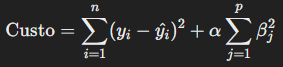

Em que:
  * 𝛽 representa os coeficientes que multiplicam as features;
  * 𝑝 é a quantidade de variáveis explicativas;
  * 𝛼 é o parâmetro de regularização.

Avaliação do valor de :

* α=0: Quando α é zero, a regressão Ridge se torna uma regressão linear padrão, sem qualquer regularização. O modelo tenta ajustar os dados o máximo possível, o que pode levar a overfitting se o modelo for muito complexo;

* α>0: À medida que α aumenta, a penalização sobre os coeficientes também aumenta, forçando-os a se aproximarem mais de zero. Isso reduz a variância do modelo, prevenindo o overfitting, mas pode aumentar o viés, o que pode levar a um modelo subajustado;

* α muito grande: Se α for muito grande, todos os coeficientes podem ser fortemente reduzidos, resultando em um modelo que pode ser muito simples e incapaz de capturar a complexidade dos dados.

#### 6.1.2 Salvar melhor configuração do algoritmo

In [ ]:
# Regressão Linear
best_params_rl = study.best_params
best_model_rl = Ridge(**best_params_rl, random_state=42)

# Recriar o pipeline com os melhores parâmetros
pipeline_best_model_rl = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('model', best_model_rl)])

# Treinar o pipeline final no conjunto de treinamento completo
pipeline_best_model_rl.fit(X_train, y_train)

# Salvando o pipeline em um arquivo .pkl
joblib.dump(pipeline_best_model_rl, '/content/drive/MyDrive/Previsao_Demandas_PoD_Academy/pipeline_best_model_all_features_linear_regression.pkl')

['/content/drive/MyDrive/Previsao_Demandas_PoD_Academy/pipeline_best_model_all_features_linear_regression.pkl']

In [ ]:
# Conferindo o desempenho da regressão linear

results = []

# Previsões no teste
test_predictions = pipeline_best_model_rl.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)

print(f"RMSE no treino: {train_rmse} \n"
      f"RMSE no teste: {test_rmse} \n"
      f"MAE no treino: {train_mae} \n"
      f"MAE no teste: {test_mae} \n"
      f"{70*'-'}")

RMSE no treino: 10948.49900478715 
RMSE no teste: 1236.3684520504019 
MAE no treino: 3395.1663829153254 
MAE no teste: 492.34729576283763 
----------------------------------------------------------------------


## 6.2. Tunar hiperparâmetros do Random Forest

In [ ]:
import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

X_train = train[features]
y_train = train[target]
X_test = val[features]
y_test = val[target]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Função objetiva para a otimização do Optuna
def objective(trial):
    # Sugerir valores para os hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 10, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    # Definir o modelo com os hiperparâmetros sugeridos
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Pipeline com o preprocessador e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])

    # Treinar o pipeline
    pipeline.fit(X_train, y_train)

    # Prever no conjunto de validação
    y_pred = pipeline.predict(X_test)

    # Calcular o erro quadrático médio
    mse = mean_squared_error(y_test, y_pred)

    return mse

class EarlyStoppingCallback:
    def __init__(self, patience: int):
        self.patience = patience
        self.best_score = None
        self.num_no_improvement = 0

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial):
        current_score = study.best_value
        if self.best_score is None or current_score < self.best_score:
            self.best_score = current_score
            self.num_no_improvement = 0
        else:
            self.num_no_improvement += 1

        if self.num_no_improvement >= self.patience:
            study.stop()

# Crie o estudo e defina o callback para parar após 10 iterações sem melhorias
early_stopping = EarlyStoppingCallback(patience=10)

# Criação do estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=70, n_jobs=-1, callbacks=[early_stopping])

# Melhor conjunto de hiperparâmetros encontrado
print(f"Melhores hiperparâmetros: {study.best_params}")
print(f"Melhor MSE: {study.best_value:.4f}")

#### 6.2.1. Conhecendo um pouco mais dos hiperparâmetros que fizemos o "tuning" no Random Forest

1.   `n_estimators` = Define o número de árvores (estimators) que serão usadas no modelo. É relevante para algoritmos baseados em ensembles, como Random Forest ou Gradient Boosting. Em caso de poucos estimators pode resultar em um modelo subajustado, pois poucas árvores podem não capturar suficientemente a complexidade dos dados. Nos cenários de muitos estimators geralmente promove melhora na performance do modelo, mas pode aumentar o tempo de treinamento e potencialmente levar a overfitting se o modelo for muito complexo;

2.   `max_depth` = Controla a profundidade máxima das árvores no modelo. Limita o número de divisões que podem ser feitas em cada árvore. Em caso de profundidade pequena pode resultar em árvores muito simples, que capturam menos padrões, podendo levar a um modelo subajustado (alto viés). Nos cenários de profundidade grande pode levar a árvores muito complexas, que capturam muitos detalhes, aumentando o risco de overfitting (alta variância);

3.   `min_samples_split ` = Define o número mínimo de amostras necessárias para dividir um nó interno. Controla o momento em que uma árvore decide criar um nó filho. Em caso de valores baixos permite que o modelo faça divisões mesmo quando há poucas amostras, o que pode resultar em árvores mais profundas e complexas, com maior risco de overfitting. Nos cenários de valores mais altos exige mais amostras para dividir um nó, o que pode resultar em árvores mais simples e menos propensas ao overfitting, mas que podem não capturar tanta complexidade nos dados;

4.   `min_samples_leaf ` = Define o número mínimo de amostras que um nó folha deve ter. Afeta o tamanho das folhas na árvore. Em caso de valores baixos permite que folhas tenham poucas amostras, o que pode resultar em folhas muito pequenas e o modelo pode overfittar, especialmente em dados ruidosos. Nos cenários de valores mais altos garante que cada folha tenha um número maior de amostras, resultando em árvores mais equilibradas e robustas, mas que podem ser mais generalistas;

5.   `max_features ` = Controla o número de features (variáveis independentes) a serem consideradas para encontrar a melhor divisão em cada nó. Opções sugeridas:
* 'sqrt': Usa a raiz quadrada do número total de features. Este é o padrão para Random Forest. Em geral, permite considerar um número maior de features, o que pode levar a divisões mais precisas e um modelo ligeiramente mais complexo.
* 'log2': Usa o logaritmo base 2 do número total de features. Considera menos features, o que pode resultar em árvores mais diversificadas e ajudar a prevenir overfitting, mas potencialmente a um custo de menor acurácia.

In [ ]:
# Random Forest
best_params_rf = study.best_params
best_model_rf = RandomForestRegressor(**best_params_rf, random_state=42)

# Recriar o pipeline com os melhores parâmetros
pipeline_best_model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('model', best_model_rf)])

# Treinar o pipeline final no conjunto de treinamento completo
pipeline_best_model_rf.fit(X_train, y_train)

# Salvando o pipeline em um arquivo .pkl
joblib.dump(pipeline_best_model_rf, '/content/drive/MyDrive/Previsao_Demandas_PoD_Academy/pipeline_best_model_all_features_random_forest.pkl')

In [ ]:
# Conferindo o desempenho do random forest

results = []

# Previsões no teste
test_predictions = pipeline_best_model_rf.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)

print(f"RMSE no treino: {train_rmse} \n"
      f"RMSE no teste: {test_rmse} \n"
      f"MAE no treino: {train_mae} \n"
      f"MAE no teste: {test_mae} \n"
      f"{70*'-'}")

RMSE no treino: 10948.49900478715 
RMSE no teste: 1435.7433002859768 
MAE no treino: 3395.1663829153254 
MAE no teste: 475.54334630367293 
----------------------------------------------------------------------


# 6.3. Tunar hiperparâmetros do LSTM

In [ ]:
import optuna
from optuna.samplers import TPESampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Input

# Definindo as variáveis
X_train = train[features]
y_train = train[target]
X_test = val[features]
y_test = val[target]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Função para criar e compilar o modelo LSTM
def create_lstm_model(trial, input_shape):
    lstm_units = trial.suggest_int('lstm_units', 10, 100)
    dense_units = trial.suggest_int('dense_units', 1, 50)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(lstm_units, activation='relu'))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Função objetiva para a otimização do Optuna
def objective(trial):

    # Preprocessamento dos dados
    X_train_scaled = pipeline.fit_transform(X_train, y_train)
    X_test_scaled = pipeline.transform(X_test)

    # Redimensionar os dados para o formato esperado pela LSTM
    X_train_scaled_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_scaled_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    # Criar o modelo LSTM usando os hiperparâmetros sugeridos
    model = create_lstm_model(trial, input_shape=(1, X_train_scaled.shape[1]))

    # Treinar o modelo LSTM
    model.fit(X_train_scaled_reshaped, y_train, epochs=trial.suggest_int('epochs', 10, 50), batch_size=32, verbose=0)

    # Prever no conjunto de validação
    y_pred = model.predict(X_test_scaled_reshaped)

    # Calcular o erro quadrático médio
    mse = mean_squared_error(y_test, y_pred)

    return mse

class EarlyStoppingCallback:
    def __init__(self, patience: int):
        self.patience = patience
        self.best_score = None
        self.num_no_improvement = 0

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial):
        current_score = study.best_value
        if self.best_score is None or current_score < self.best_score:
            self.best_score = current_score
            self.num_no_improvement = 0
        else:
            self.num_no_improvement += 1

        if self.num_no_improvement >= self.patience:
            study.stop()

# Crie o estudo e defina o callback para parar após 10 iterações sem melhorias
early_stopping = EarlyStoppingCallback(patience=10)

# Criação do estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=70, n_jobs=-1, callbacks=[early_stopping])

# Melhor conjunto de hiperparâmetros encontrado
print(f"Melhores hiperparâmetros: {study.best_params}")
print(f"Melhor MSE: {study.best_value:.4f}")

[I 2024-08-22 04:33:47,102] A new study created in memory with name: no-name-e1a196f0-bcb6-4887-bd45-d1d40a5ba491


243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


[I 2024-08-22 04:38:16,315] Trial 1 finished with value: 1254673.2860420435 and parameters: {'lstm_units': 83, 'dense_units': 8, 'optimizer': 'rmsprop', 'epochs': 11}. Best is trial 1 with value: 1254673.2860420435.


243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


[I 2024-08-22 04:39:26,009] Trial 0 finished with value: 1239278.7741041784 and parameters: {'lstm_units': 79, 'dense_units': 17, 'optimizer': 'rmsprop', 'epochs': 16}. Best is trial 0 with value: 1239278.7741041784.


243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2024-08-22 04:45:53,210] Trial 3 finished with value: 1198113.1755529651 and parameters: {'lstm_units': 74, 'dense_units': 5, 'optimizer': 'rmsprop', 'epochs': 18}. Best is trial 3 with value: 1198113.1755529651.


243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2024-08-22 04:58:37,813] Trial 2 finished with value: 3256981.7661046344 and parameters: {'lstm_units': 79, 'dense_units': 49, 'optimizer': 'adam', 'epochs': 45}. Best is trial 3 with value: 1198113.1755529651.


243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


[I 2024-08-22 05:03:13,680] Trial 4 finished with value: 2425519.292041037 and parameters: {'lstm_units': 59, 'dense_units': 12, 'optimizer': 'adam', 'epochs': 50}. Best is trial 3 with value: 1198113.1755529651.


243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


[I 2024-08-22 05:08:54,771] Trial 6 finished with value: 1329532.1947127213 and parameters: {'lstm_units': 32, 'dense_units': 31, 'optimizer': 'adam', 'epochs': 17}. Best is trial 3 with value: 1198113.1755529651.


243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-08-22 05:11:32,337] Trial 5 finished with value: 1668369.5862653793 and parameters: {'lstm_units': 34, 'dense_units': 45, 'optimizer': 'rmsprop', 'epochs': 41}. Best is trial 3 with value: 1198113.1755529651.


243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


[I 2024-08-22 05:15:12,069] Trial 8 finished with value: 414950327.88924277 and parameters: {'lstm_units': 22, 'dense_units': 5, 'optimizer': 'rmsprop', 'epochs': 12}. Best is trial 3 with value: 1198113.1755529651.


243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


[I 2024-08-22 05:20:46,042] Trial 7 finished with value: 1986777.6792679403 and parameters: {'lstm_units': 97, 'dense_units': 14, 'optimizer': 'rmsprop', 'epochs': 30}. Best is trial 3 with value: 1198113.1755529651.


243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


[I 2024-08-22 05:28:38,278] Trial 9 finished with value: 2652143.594538275 and parameters: {'lstm_units': 71, 'dense_units': 12, 'optimizer': 'adam', 'epochs': 37}. Best is trial 3 with value: 1198113.1755529651.


243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


[I 2024-08-22 05:33:05,648] Trial 10 finished with value: 413459298.25428694 and parameters: {'lstm_units': 37, 'dense_units': 4, 'optimizer': 'rmsprop', 'epochs': 39}. Best is trial 3 with value: 1198113.1755529651.


243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


[I 2024-08-22 05:36:23,066] Trial 11 finished with value: 1686024.196562273 and parameters: {'lstm_units': 50, 'dense_units': 29, 'optimizer': 'rmsprop', 'epochs': 24}. Best is trial 3 with value: 1198113.1755529651.


243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


[I 2024-08-22 05:41:25,847] Trial 12 finished with value: 1698644.9037626472 and parameters: {'lstm_units': 60, 'dense_units': 25, 'optimizer': 'rmsprop', 'epochs': 23}. Best is trial 3 with value: 1198113.1755529651.


243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2024-08-22 05:44:59,111] Trial 13 finished with value: 1386752.2105204526 and parameters: {'lstm_units': 100, 'dense_units': 20, 'optimizer': 'rmsprop', 'epochs': 22}. Best is trial 3 with value: 1198113.1755529651.


Melhores hiperparâmetros: {'lstm_units': 74, 'dense_units': 5, 'optimizer': 'rmsprop', 'epochs': 18}
Melhor MSE: 1198113.1756


In [10]:
best_params_lstm = study.best_params
best_params_lstm

{'lstm_units': 74, 'dense_units': 5, 'optimizer': 'rmsprop', 'epochs': 18}

In [ ]:
# Função para criar e compilar o modelo LSTM usando os melhores hiperparâmetros
def create_best_lstm_model(params, input_shape):
    lstm_units = params['lstm_units']
    dense_units = params['dense_units']
    optimizer = params['optimizer']

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=lstm_units, input_shape=input_shape))
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dense(1, activation='linear'))  # Saída para regressão

    model.compile(optimizer=optimizer, loss='mse')
    return model

In [ ]:
# LSTM

# Recriar o pipeline com os melhores parâmetros
pipeline_dataprep_lstm = Pipeline(steps=[('preprocessor', preprocessor)])

# Preprocessamento dos dados
X_train_np = pipeline_dataprep_lstm.fit_transform(X_train)
X_test_np = pipeline_dataprep_lstm.transform(X_test)

# Redimensionar os dados para o formato esperado pela LSTM
X_train_scaled = X_train_np.reshape((X_train_np.shape[0], 1, X_train_np.shape[1]))
X_test_scaled = X_test_np.reshape((X_test_np.shape[0], 1, X_test_np.shape[1]))

# Criar o modelo LSTM usando os melhores hiperparâmetros encontrados pelo Optuna
model = create_best_lstm_model(best_params_lstm, input_shape=(1, X_train_scaled.shape[2]))

# Treinar o modelo LSTM usando os melhores parâmetros
model.fit(X_train_scaled, y_train, epochs=best_params_lstm['epochs'], batch_size=best_params_lstm.get('batch_size', 32), verbose=1)

# Se quiser, salvar o modelo treinado
model.save('/content/drive/MyDrive/Previsao_Demandas_PoD_Academy/best_lstm_model.h5')

# Salvar o dataprep
joblib.dump(pipeline_dataprep_lstm, '/content/drive/MyDrive/Previsao_Demandas_PoD_Academy/pipeline_dataprep_lstm.pkl')

Epoch 1/18


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4210/4210 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 376009920.0000
Epoch 2/18
4210/4210 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 327957664.0000
Epoch 3/18
4210/4210 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 254699680.0000
Epoch 4/18
4210/4210 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 181766816.0000
Epoch 5/18
4210/4210 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 125626408.0000
Epoch 6/18
4210/4210 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 86644696.0000
Epoch 7/18
4210/4210 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 56501808.0000
Epoch 8/18
4210/4210 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 32600960.0000
Epoch 9/18
4210/4210 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 16365732.0000
Epoch 10/18
4210/4210 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 8917508.0000
Epoch 11/18
4210/4210 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 6998524.5000
Epoch 12/18
4210/4210 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 6285768.5000
Epoch 13/18
4210/4210 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 5968249.0000
Epoch

['/content/drive/MyDrive/Previsao_Demandas_PoD_Academy/pipeline_dataprep_lstm.pkl']

#### 6.2.1. Conhecendo um pouco mais dos hiperparâmetros que fizemos o "tuning" no LSTM

1.   `lstm_units ` = Define o número de unidades na camada LSTM. Essas unidades são os "neurônios" da camada LSTM que armazenam e processam informações ao longo de sequências temporais, capturando dependências temporais de curto e longo prazo. Em caso de Menor número de unidades pode ser mais rápido de treinar e consumir menos memória, mas pode não capturar todas as nuances temporais dos dados, levando a uma perda de precisão. Nos cenários de maior número de unidades pode capturar mais detalhes e padrões complexos nos dados sequenciais, mas ao custo de maior tempo de treinamento e maior risco de overfitting se não for bem regularizado;

2.   `dense_units` = Define o número de unidades na camada densa (fully connected). Essa camada é geralmente usada após a(s) camada(s) LSTM para combinar as features extraídas e produzir a saída final. Em caso de menor número de unidades pode simplificar o modelo, tornando-o mais rápido de treinar, mas pode não ser suficiente para capturar todos os padrões complexos dos dados. Nos cenários de maior número de unidades pode permitir que o modelo aprenda mais representações complexas, mas com o risco de overfitting e maior custo computacional;

3.   `optimizer` = Especifica o algoritmo de otimização usado para ajustar os pesos do modelo durante o treinamento. Opções sugeridas:
* adam: Um otimizador muito popular que combina as vantagens do método de gradiente estocástico (SGD) com momentos adaptativos, ajustando automaticamente a taxa de aprendizado. É eficiente e geralmente funciona bem em uma ampla gama de problemas. Tende a ser uma escolha padrão por sua robustez e capacidade de convergir rapidamente para um bom conjunto de pesos. Funciona bem em uma ampla variedade de problemas, incluindo séries temporais;

* rmsprop: Outro otimizador adaptativo que ajusta a taxa de aprendizado com base nas médias quadradas dos gradientes recentes. É especialmente eficaz para redes neurais recorrentes (como LSTM) e pode lidar bem com a diminuição dos gradientes (vanishing gradient problem). Frequentemente escolhido para problemas onde a arquitetura de rede é recorrente, como LSTM, devido à sua habilidade em lidar com gradientes que explodem ou desaparecem.

## 6.4. Aplicação do Voting Ensemble

### 6.4.1 Ajuste para o LSTM

In [11]:
# Carregar o dataprep para o LSTM
pipeline_dataprep_lstm = joblib.load('/content/drive/MyDrive/Previsao_Demandas_PoD_Academy/pipeline_dataprep_lstm.pkl')

# Preprocessamento dos dados
X_train_np = pipeline_dataprep_lstm.fit_transform(X_train)
X_test_np = pipeline_dataprep_lstm.transform(X_test)

# Redimensionar os dados para o formato esperado pela LSTM
X_train_scaled = X_train_np.reshape((X_train_np.shape[0], 1, X_train_np.shape[1]))
X_test_scaled = X_test_np.reshape((X_test_np.shape[0], 1, X_test_np.shape[1]))

from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

# Registrar 'mse' como uma métrica personalizada
custom_objects = {'mse': MeanSquaredError()}

# Carregar o modelo LSTM salvo
model = load_model('/content/drive/MyDrive/Previsao_Demandas_PoD_Academy/best_lstm_model.h5', custom_objects=custom_objects)

### 6.4.2 Combinação de algoritmos

In [12]:
import joblib
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Carregar os modelos salvos
pipeline_best_model_rf = joblib.load('/content/drive/MyDrive/Previsao_Demandas_PoD_Academy/pipeline_best_model_all_features_random_forest.pkl')
pipeline_best_model_rl = joblib.load('/content/drive/MyDrive/Previsao_Demandas_PoD_Academy/pipeline_best_model_all_features_linear_regression.pkl')
pipeline_best_model_catboost = joblib.load('/content/drive/MyDrive/Previsao_Demandas_PoD_Academy/pipeline_best_model_all_features_catboost.pkl')

# Fazer previsões no conjunto de teste
preds_rf = pipeline_best_model_rf.predict(X_test)
preds_rl = pipeline_best_model_rl.predict(X_test)
preds_catboost = pipeline_best_model_catboost.predict(X_test)
preds_lstm = model.predict(X_test_scaled)[:,0]

# Voting Ensemble (média das previsões)
preds_voting_ensemble = np.mean([preds_rf, preds_rl, preds_catboost, preds_lstm], axis=0)

# Avaliar o desempenho dos modelos base
def evaluate_model(predictions, true_values, model_name):
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)
    print(f"{model_name} - MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R2: {r2}")

print("Avaliação dos Modelos Base:")
evaluate_model(preds_rf, y_test, "Random Forest")
evaluate_model(preds_rl, y_test, "Linear Regression")
evaluate_model(preds_catboost, y_test, "CatBoost")
evaluate_model(preds_lstm, y_test, "LSTM")


# Avaliar o desempenho do Voting Ensemble
print("\nAvaliação do Voting Ensemble:")
evaluate_model(preds_voting_ensemble, y_test, "Voting Ensemble")

243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Avaliação dos Modelos Base:
Random Forest - MSE: 2061358.8243160688, RMSE: 1435.7433002859768, MAE: 475.54334630367293, R2: 0.994300340683071
Linear Regression - MSE: 1528606.9259785837, RMSE: 1236.3684426491093, MAE: 492.3472948521119, R2: 0.9957734002422084
CatBoost - MSE: 1008454.3757621698, RMSE: 1004.2182908920599, MAE: 442.2136885003837, R2: 0.9972116225905416
LSTM - MSE: 1468013.4199285624, RMSE: 1211.616036510149, MAE: 427.38350366092976, R2: 0.995940941350156

Avaliação do Voting Ensemble:
Voting Ensemble - MSE: 1040002.8792523165, RMSE: 1019.8053143871709, MAE: 373.59428326967065, R2: 0.9971243909452154


# 7. Análise da distribuição dos erros

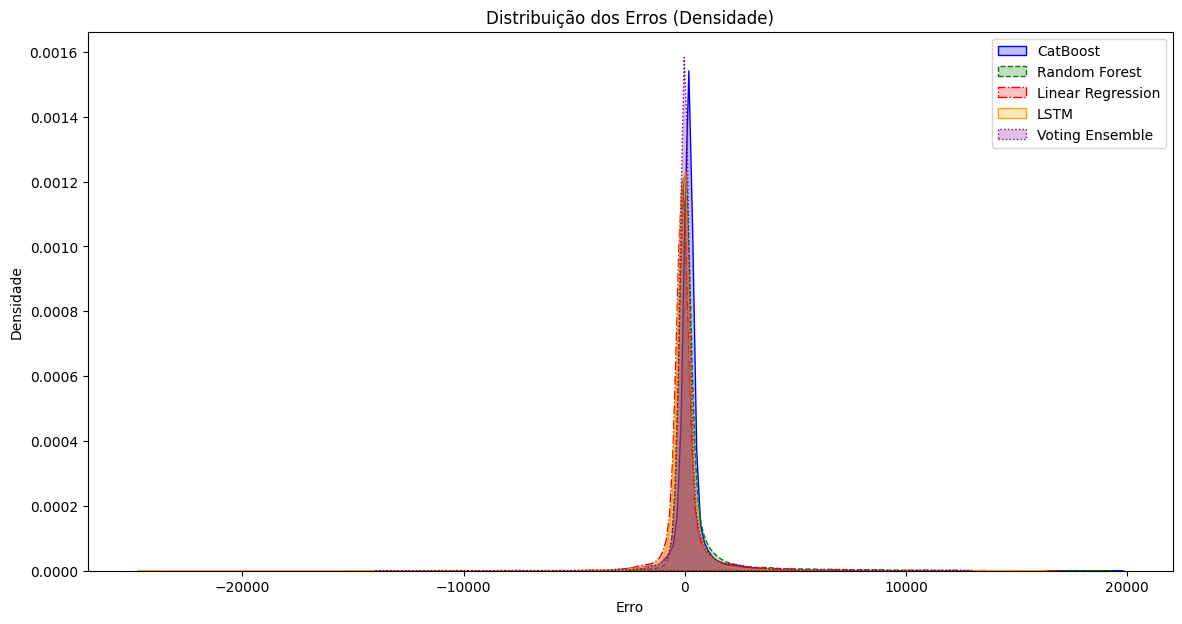

In [13]:
# Calcular os erros (resíduos)
errors_catboost = preds_catboost - y_test
errors_rf = preds_rf - y_test
errors_rl = preds_rl - y_test
errors_lstm = preds_lstm - y_test
errors_voting = preds_voting_ensemble - y_test  # Erros do Voting Ensemble

# Criar um DataFrame para os erros
errors_df = pd.DataFrame({
    'Erro': np.concatenate([errors_catboost, errors_rf, errors_rl, errors_lstm, errors_voting]),
    'Modelo': ['CatBoost'] * len(errors_catboost) + ['Random Forest'] * len(errors_rf) + ['Linear Regression'] * len(errors_rl) + ['LSTM'] * len(errors_lstm) + ['Voting Ensemble'] * len(errors_voting)
})

# Plotar gráficos de densidade dos erros
plt.figure(figsize=(14, 7))
sns.kdeplot(errors_catboost, label='CatBoost', fill=True, color='blue', linestyle='-')
sns.kdeplot(errors_rf, label='Random Forest', fill=True, color='green', linestyle='--')
sns.kdeplot(errors_rl, label='Linear Regression', fill=True, color='red', linestyle='-.')
sns.kdeplot(errors_lstm, label='LSTM', fill=True, color='orange', linestyle='-')
sns.kdeplot(errors_voting, label='Voting Ensemble', fill=True, color='purple', linestyle=':')
plt.title('Distribuição dos Erros (Densidade)')
plt.xlabel('Erro')
plt.ylabel('Densidade')
plt.legend()
plt.show()

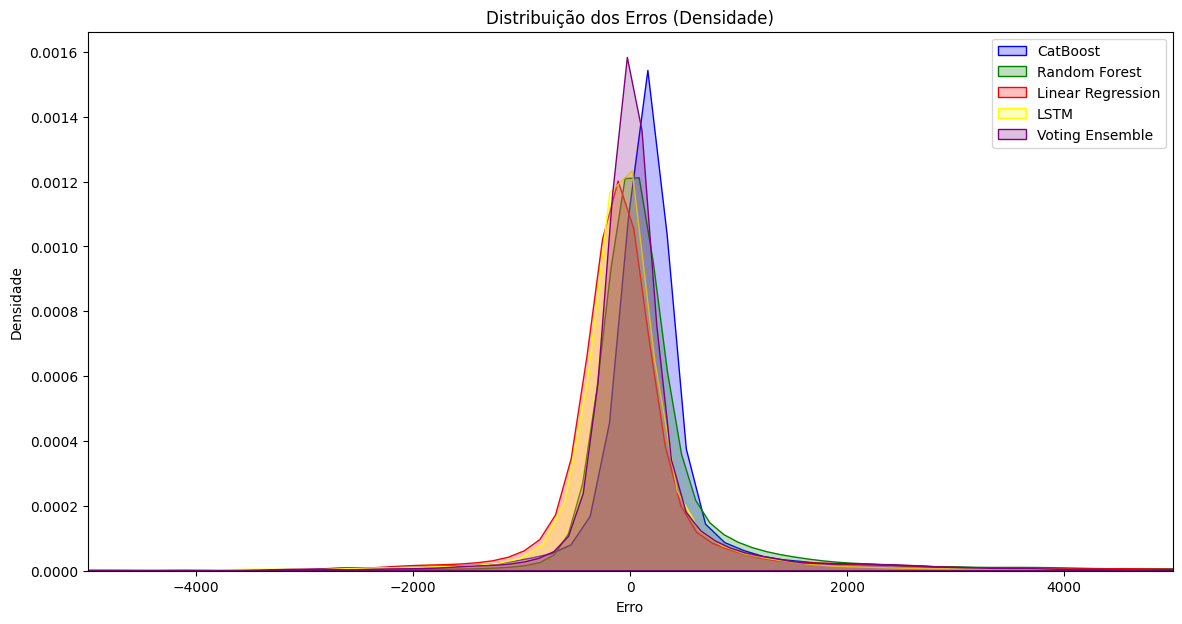

In [14]:
# Ajustando escala do gráfico
plt.figure(figsize=(14, 7))
sns.kdeplot(errors_catboost, label='CatBoost', fill=True, color='blue')
sns.kdeplot(errors_rf, label='Random Forest', fill=True, color='green')
sns.kdeplot(errors_rl, label='Linear Regression', fill=True, color='red')
sns.kdeplot(errors_lstm, label='LSTM', fill=True, color='yellow')
sns.kdeplot(errors_voting, label='Voting Ensemble', fill=True, color='purple')
plt.title('Distribuição dos Erros (Densidade)')
plt.xlabel('Erro')
plt.ylabel('Densidade')
plt.xlim([-5000, 5000])  # Ajustar o limite conforme necessário
plt.legend()
plt.show()